# COVID-19 Vaccine Forecast

## Part 4 - Forecasting

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

from keras import backend as K

from math import sqrt
import time
import os
import joblib
import random

In [2]:
# create function that sets OS `PYTHONHASHSEED` environment variable,
# Python, NumPy, and TensorFlow seeds at a fixed value
def reset_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    random.seed(42)
    np.random.seed(42)
    set_random_seed(42)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

reset_seeds()

2022-09-22 23:55:23.251425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# read in clean massachussets data into a pandas dataframe
df = pd.read_csv('../data/massachusetts_vaccinations_09_04_21_clean.csv')

### LSTM Preprocessing

In [4]:
# convert feature of interest to a single df column
data = df[['total_vaccinations']]

In [5]:
# define function that fits minmaxscaler on train data and
# and transforms both train and test data
# scaler is pickled in order to inverse_transform values later
def data_normalization(data, test_window):
    train_data = data[:test_window]
    test_data = data[test_window:]
    scaler = MinMaxScaler()
    train_sc = scaler.fit_transform(train_data)
    test_sc = scaler.transform(test_data)
    joblib.dump(scaler, '../data/scaler_1.pkl')
    data_sc = np.append(train_sc, test_sc)
    return data_sc

In [6]:
# set length of test window
test_window = len(data)-7

# run data through data normalization function
data_sc = data_normalization(data, test_window)

In [7]:
# create function that separates data into X and y
# each X value is an array whose length is specified by the "n_steps" argument
def sampling(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):     
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, Y = sequence[i:sam], sequence[sam]
        X.append(x)
        y.append(Y)
    return np.array(X), np.array(y)

In [8]:
# specify number of steps
n_steps = 1

# run data through the sampling function
X, y = sampling(data_sc, n_steps)

In [9]:
# check shape of X and Y
X.shape, y.shape

((234, 1), (234,))

In [10]:
# set size of test window
test_window = len(X)-7

# split X and y into train and test
X_train, y_train = X[:test_window], y[:test_window]
X_test, y_test = X[test_window:], y[test_window:]

#convert data into suitable dimension for using it as input in LSTM network
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(227, 1, 1) (227, 1) (7, 1, 1) (7, 1)


In [11]:
# assign input shape for LSTM gridsearch
input_shape = (X_train.shape[1], X_train.shape[2])
# check input shape
input_shape

(1, 1)

### Using GridSearch parameters to build LSTM RNN

#### Model 1

In [12]:
# load in gridsearch 1 best paramter results
gs_1 = joblib.load("../data/gs_1.pkl")
gs_1

{'epochs': 50, 'hidden_neurons': 8, 'learning_rate': 0.0005}

In [13]:
# creating RNN using gridsearch_1 parameters
model = Sequential()
model.add(LSTM(8, input_shape=input_shape))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.0005), metrics=['mae'])

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
# look at summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fit model and set results equal to history
history = model.fit(X_train, y_train, epochs=50, verbose=0, shuffle=False, batch_size=1)

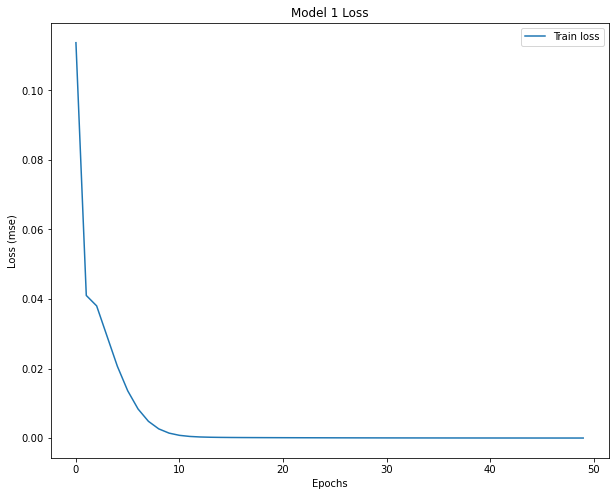

In [16]:
# plot loss
plt.figure(figsize=(10,8))
plt.xlabel("Epochs")
plt.ylabel("Loss (mse)")
plt.title("Model 1 Loss")
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

#### One-step Forecasting

In [17]:
# create predictions on X_test values using model 1
preds = model.predict(X_test)

1/1 [==============================] - 1s 674ms/step


In [18]:
# load minmaxscaler
scaler = joblib.load("../data/scaler_1.pkl")

In [19]:
# inverse transform normalized predictions to actual predictions
inv_test_preds = scaler.inverse_transform(preds)
inv_test_preds

array([[9448242.],
       [9458716.],
       [9471756.],
       [9480890.],
       [9492261.],
       [9505714.],
       [9520018.]], dtype=float32)

In [20]:
# inverse transform normalized y_test values to actual y_test values
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[9448906.],
       [9462566.],
       [9472140.],
       [9484059.],
       [9498168.],
       [9513175.],
       [9527318.]])

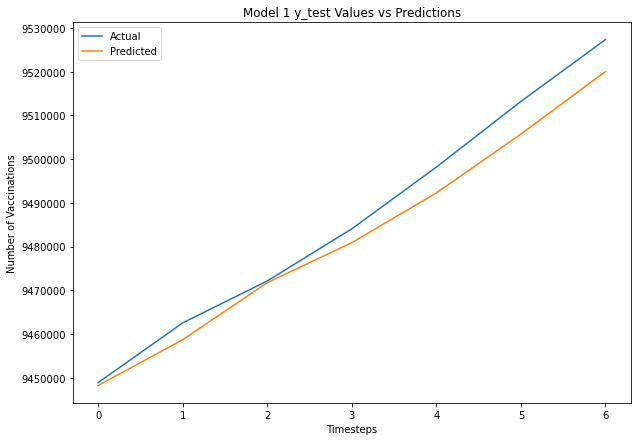

In [21]:
# plot model 1 single step predictions vs actual values
fig, ax = plt.subplots(figsize=(10,7))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 1 y_test Values vs Predictions')
plt.plot(inv_y_test,label="Actual")
plt.plot(inv_test_preds,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

In [22]:
# calculate rmse of y_test actual and one step model 1 predicted values
rmse = sqrt(mean_squared_error(inv_y_test, inv_test_preds))
print(F'RMSE: {rmse}')

RMSE: 4917.93485984845


In [23]:
# create function for MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual-pred)/actual))*100

In [24]:
# calculate MAPE of y_test values and one step model 1 predicted values
os_mape = mape(inv_y_test, inv_test_preds)
print(F'MAPE percentage: {round(os_mape, 2)}%')

MAPE percentage: 0.04%


#### Recursive Multi-step Forecasting

In [25]:
# create empty predicitions list
test_predictions = []

# select last n_input values from the train data
n_input = 1
n_features = 1

# reshape the data into LSTM required (#batch,#timesteps,#features)
# h/t stackoverflow
first_eval_batch = X_test[0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
# get prediction, grab the exact number using the [0]
    current_pred = model.predict(current_batch)[0]
# add this prediction to the list
    test_predictions.append(current_pred)
# update the (#batch,#timesteps,#features) using np.append
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 19ms/step


In [26]:
# inverse transform normalized multi-step predictions to actual predictions
inv_preds = scaler.inverse_transform(test_predictions)
inv_preds

array([[9448241.6070025 ],
       [9458080.26566255],
       [9467472.66184735],
       [9476436.38225543],
       [9484987.91441667],
       [9493145.94419825],
       [9500925.85996139]])

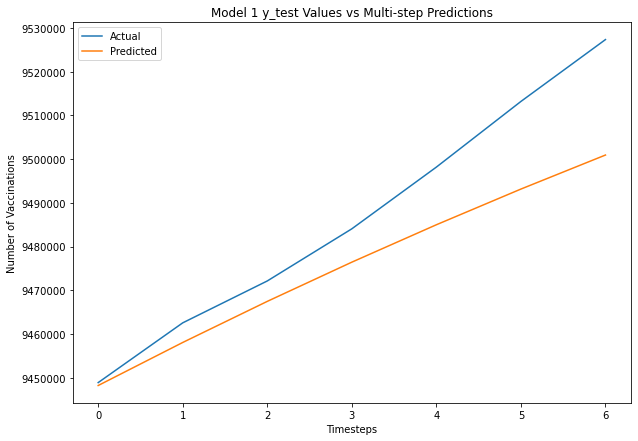

In [27]:
# plot model 1 recursive predictions vs actual values
fig, ax = plt.subplots(figsize=(10,7))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 1 y_test Values vs Multi-step Predictions')
plt.plot(inv_y_test,label="Actual")
plt.plot(inv_preds,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

In [28]:
# calculate rmse of y_test actual values and recursive model 1 predicted values
rmse = sqrt(mean_squared_error(inv_y_test, inv_preds))
print(F'RMSE: {rmse}')

RMSE: 13999.358992586695


In [29]:
# calculate MAPE of y_test values and recursive model 1 predicted values
rec_mape = mape(inv_y_test, inv_preds)
print(F'MAPE percentage: {round(rec_mape, 2)}%')

MAPE percentage: 0.12%


In [30]:
# # save first model because results look promising
# model.save("../data/model_1.h1")

#### Model 2 - best dropout and batch size parameters

In [31]:
# load in gridsearch 2 best parameter results
gs_2 = joblib.load("../data/gs_2.pkl")
gs_2

{'batch_size': 1, 'dropout': 0.8, 'hidden_neurons': 32}

In [32]:
# reset seeds in order to preserve reproducibility
reset_seeds()

In [33]:
# creating RNN using gridsearch_2 parameters
model = Sequential()
model.add(LSTM(32, input_shape=input_shape))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.0005), metrics=['mae'])

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
# look at summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [35]:
# fit model and set results equal to history
history = model.fit(X_train, y_train, epochs=50, verbose=0, shuffle=False, batch_size=1)

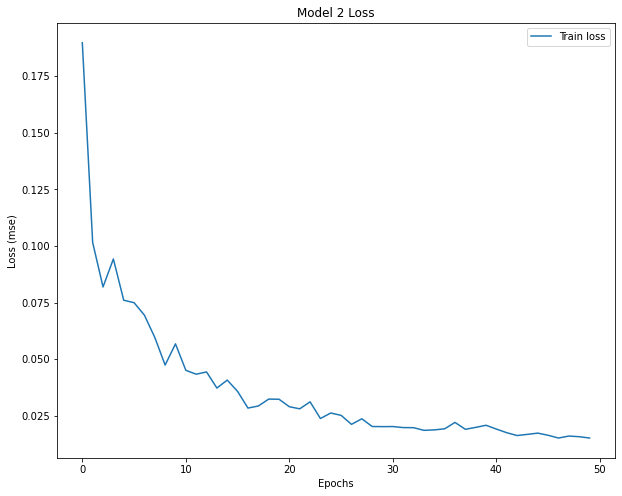

In [36]:
# plot loss
plt.figure(figsize=(10,8))
plt.xlabel("Epochs")
plt.ylabel("Loss (mse)")
plt.title("Model 2 Loss")
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

#### One-step Forecasting

In [37]:
# create predictions on X_test values using model 2
preds = model.predict(X_test)

1/1 [==============================] - 0s 406ms/step


In [38]:
# inverse transform normalized predictions to actual predictions
inv_test_preds = scaler.inverse_transform(preds)
inv_test_preds

array([[9345606.],
       [9356501.],
       [9370075.],
       [9379591.],
       [9391442.],
       [9405473.],
       [9420402.]], dtype=float32)

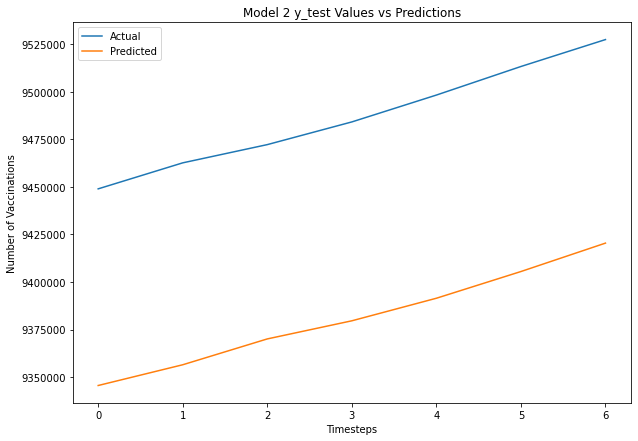

In [39]:
# plot model 2 single step predictions vs actual values
fig, ax = plt.subplots(figsize=(10,7))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 2 y_test Values vs Predictions')
plt.plot(inv_y_test,label="Actual")
plt.plot(inv_test_preds,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

In [40]:
# calculate rmse of y_test actual and single step model 2 predicted values
rmse = sqrt(mean_squared_error(inv_y_test, inv_test_preds))
print(F'RMSE: {rmse}')

RMSE: 105338.02217487391


In [41]:
# calculate MAPE of y_test values and one step model 2 predicted values
os_mape = mape(inv_y_test, inv_test_preds)
print(F'MAPE percentage: {round(os_mape, 2)}%')

MAPE percentage: 1.11%


#### Recursive Multi-step Forecasting 

In [42]:
# create empty predicitions list
test_predictions = []

# select last n_input values from the train data
n_input = 1
n_features = 1

# reshape the data into LSTM required (#batch,#timesteps,#features)
# h/t stackoverflow
first_eval_batch = X_test[0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
# get prediction, grab the exact number using the [0]
    current_pred = model.predict(current_batch)[0]
# add this prediction to the list
    test_predictions.append(current_pred)
# update the (#batch,#timesteps,#features) using np.append
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 22ms/step


In [43]:
# inverse transform normalized multi-step predictions to actual predictions
inv_preds = scaler.inverse_transform(test_predictions)
inv_preds

array([[9345605.08478481],
       [9253984.98044449],
       [9163259.04980767],
       [9073604.25902832],
       [8985192.62800145],
       [8898186.8336885 ],
       [8812740.75970161]])

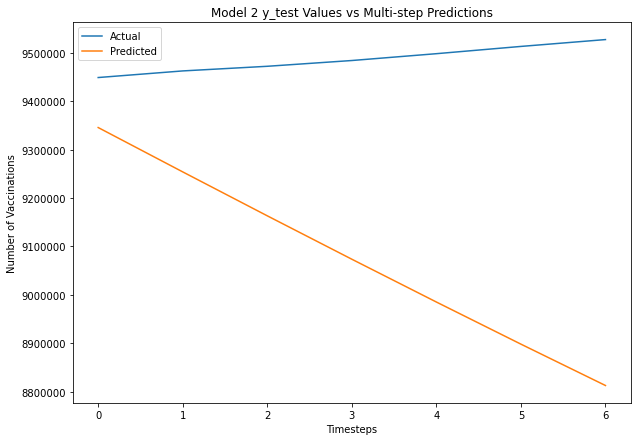

In [44]:
# plot model 1 recursive predictions vs actual values
fig, ax = plt.subplots(figsize=(10,7))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 2 y_test Values vs Multi-step Predictions')
plt.plot(inv_y_test,label="Actual")
plt.plot(inv_preds,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

In [45]:
# calculate rmse of y_test actual values and recursive model 2 predicted values
rmse = sqrt(mean_squared_error(inv_y_test, inv_preds))
print(F'RMSE: {rmse}')

RMSE: 458262.6299270599


In [46]:
# calculate MAPE of y_test values and recursive model 2 predicted values
rec_mape = mape(inv_y_test, inv_preds)
print(F'MAPE percentage: {round(rec_mape, 2)}%')

MAPE percentage: 4.32%


#### Model 3 - best dropout and learning rate parameters

In [47]:
# load in gridsearch 3 best paramter results
gs_3 = joblib.load("../data/gs_3.pkl")
gs_3

{'dropout': 0.8, 'hidden_neurons': 128, 'learning_rate': 0.001}

In [48]:
# reset seeds in order to preserve reproducability
reset_seeds()

In [49]:
# create RNN using gridsearch_3 parameters
model = Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
# view summary of model 3
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [51]:
# fit model and set results equal to history
history = model.fit(X_train, y_train, epochs=50, verbose=0, shuffle=False, batch_size=1)

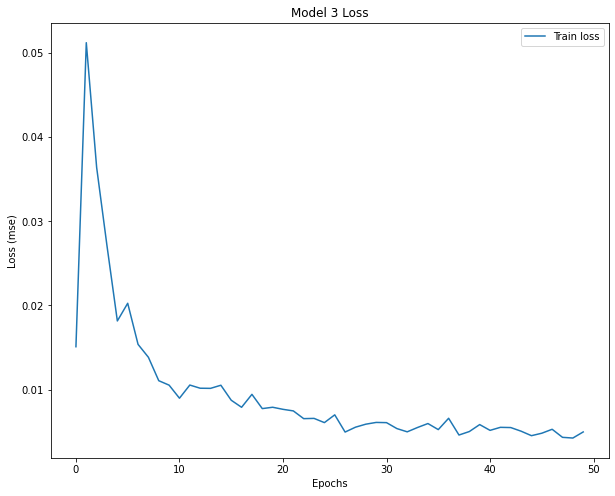

In [52]:
# plot loss
plt.figure(figsize=(10,8))
plt.xlabel("Epochs")
plt.ylabel("Loss (mse)")
plt.title("Model 3 Loss")
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

#### One-step Forecasting

In [53]:
# create predictions on X_test values using model 3
preds = model.predict(X_test)

1/1 [==============================] - 0s 405ms/step


In [54]:
# inverse transform normalized predictions to actual predictions
inv_test_preds = scaler.inverse_transform(preds)
inv_test_preds

array([[9314808.],
       [9325074.],
       [9337861.],
       [9346821.],
       [9357977.],
       [9371181.],
       [9385225.]], dtype=float32)

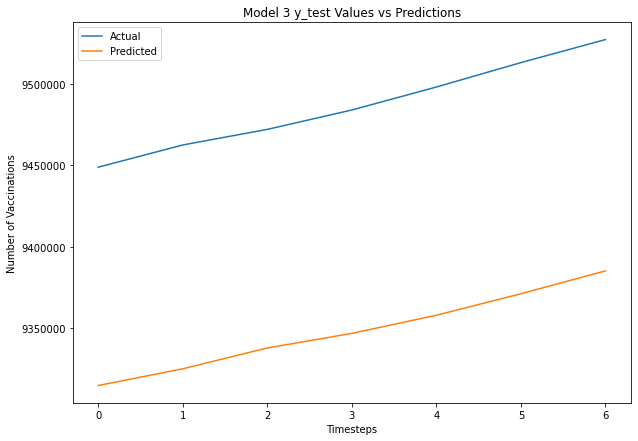

In [55]:
# plot model 3 single step predictions vs actual values
fig, ax = plt.subplots(figsize=(10,7))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 3 y_test Values vs Predictions')
plt.plot(inv_y_test,label="Actual")
plt.plot(inv_test_preds,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

In [56]:
# calculate rmse of y_test actual and single step model 3 predicted values
rmse = sqrt(mean_squared_error(inv_y_test, inv_test_preds))
print(F'RMSE: {rmse}')

RMSE: 138232.55525123465


In [57]:
# calculate MAPE of y_test values and one step model 3 predicted values
os_mape = mape(inv_y_test, inv_test_preds)
print(F'MAPE percentage: {round(os_mape, 2)}%')

MAPE percentage: 1.46%


#### Recursive Multi-step Forecasting

In [58]:
# create empty predicitions list
test_predictions = []

# select last n_input values from the train data
n_input = 1
n_features = 1

# reshape the data into LSTM required (#batch,#timesteps,#features)
# h/t stackoverflow
first_eval_batch = X_test[0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
# get prediction, grab the exact number using the [0]
    current_pred = model.predict(current_batch)[0]
# add this prediction to the list
    test_predictions.append(current_pred)
# update the (#batch,#timesteps,#features) using np.append
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

1/1 [==============================] - 0s 16ms/step


In [59]:
# inverse transform normalized multi-step predictions to actual predictions
inv_preds = scaler.inverse_transform(test_predictions)
inv_preds

array([[9314809.1269021 ],
       [9199523.3717652 ],
       [9091533.8981818 ],
       [8990334.53898478],
       [8895462.54416901],
       [8806491.43629509],
       [8723027.71298337]])

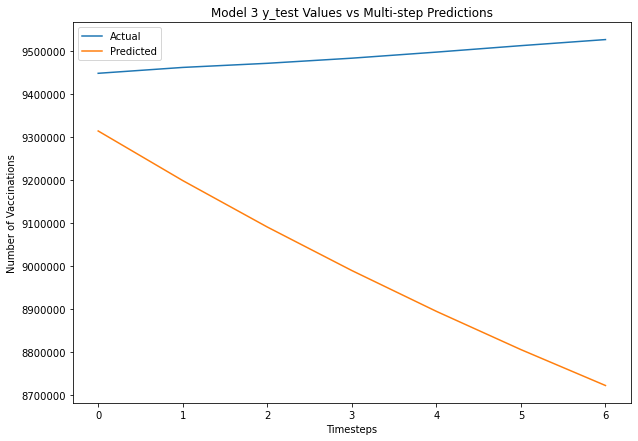

In [60]:
# plot model 3 recursive predictions vs actual values
fig, ax = plt.subplots(figsize=(10,7))

ax.yaxis.get_major_formatter().set_scientific(False)
plt.title('Model 3 y_test Values vs Multi-step Predictions')
plt.plot(inv_y_test,label="Actual")
plt.plot(inv_preds,label="Predicted")
plt.xlabel('Timesteps')
plt.ylabel('Number of Vaccinations')
plt.legend()
plt.show()

In [61]:
# calculate rmse of y_test actual values and recursive model 3 predicted values
rmse = sqrt(mean_squared_error(inv_y_test, inv_preds))
print(F'RMSE: {rmse}')

RMSE: 532559.4045037514


In [62]:
# calculate MAPE of y_test values and recursive model 3 predicted values
rec_mape = mape(inv_y_test, inv_preds)
print(F'MAPE percentage: {round(rec_mape, 2)}%')

MAPE percentage: 5.09%


### Utilize Production Model to Evaluate Distribution of RMSE Scores

Although seeds were initially set and reset in order to preserve reproducibility, repeat experiments will yield a distribution of different results due to the randomness of the initial weights when running keras models.

Model 1 had promising results, let's check what the distribution of RMSE scores for recursive multi-step forecasting are when the model is run 30 times!

In [63]:
# reset seeds to preserve reproducability
reset_seeds()

In [64]:
# view model 1 parameters
gs_1

{'epochs': 50, 'hidden_neurons': 8, 'learning_rate': 0.0005}

In [65]:
# create RNN function
def fit_prod_lstm(X, y, neurons, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=['mae'])
    
    model.fit(X, y, epochs=50, verbose=0, shuffle=False, batch_size=1)
    
    return model

In [66]:
# repeat experiment 30 times
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
    lstm_model = fit_prod_lstm(X_train, y_train, 8, 0.0005)
    # Create empty predicitions list
    test_predictions=[]
    #Select last n_input values from the train data
    n_input = 1
    n_features = 1
    #reshape the data into LSTM required (#batch,#timesteps,#features)
    first_eval_batch = X_test[0]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    for i in range(len(X_test)):
    # get prediction, grab the exact number using the [0]
        current_pred = lstm_model.predict(current_batch)[0]
    # Add this prediction to the list
        test_predictions.append(current_pred)
    # Update the (#batch,#timesteps,#features) using np.append
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)
	# report performance
    inv_preds = scaler.inverse_transform(test_predictions)
    rmse = sqrt(mean_squared_error(inv_y_test, inv_preds))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
1) Test RMSE: 13999.359


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 20ms/step
2) Test RMSE: 15458.468


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
3) Test RMSE: 18006.004


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
4) Test RMSE: 18823.614


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
5) Test RMSE: 15815.522


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 20ms/step
6) Test RMSE: 18370.318


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 25ms/step
7) Test RMSE: 16594.359


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
8) Test RMSE: 13934.959


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
9) Test RMSE: 14933.350


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 16ms/step
10) Test RMSE: 12116.393


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
11) Test RMSE: 19363.472


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 21ms/step
12) Test RMSE: 13475.983


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 21ms/step
13) Test RMSE: 18167.553


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 44ms/step
14) Test RMSE: 14703.070


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 17ms/step
15) Test RMSE: 8366.281


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
16) Test RMSE: 15233.448


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
17) Test RMSE: 14565.629


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
18) Test RMSE: 15607.505


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
19) Test RMSE: 18013.245


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 16ms/step
20) Test RMSE: 12505.320


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
21) Test RMSE: 13882.206


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 20ms/step
22) Test RMSE: 20011.661


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 19ms/step
23) Test RMSE: 14642.363


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
24) Test RMSE: 16807.517


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
25) Test RMSE: 17265.859


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 16ms/step
26) Test RMSE: 10909.058


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 16ms/step
27) Test RMSE: 19088.311


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 15ms/step
28) Test RMSE: 16351.531


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 14ms/step
29) Test RMSE: 17853.061


/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 14ms/step
30) Test RMSE: 18790.663


               rmse
count     30.000000
mean   15788.536060
std     2718.523333
min     8366.280653
25%    14140.926512
50%    15711.513365
75%    18011.434928
max    20011.660992


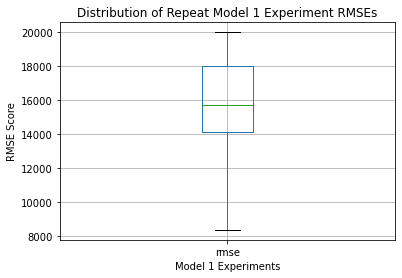

In [67]:
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.xlabel("Model 1 Experiments")
plt.ylabel("RMSE Score")
plt.title("Distribution of Repeat Model 1 Experiment RMSEs")
plt.show()